In [2]:
# для загрузки данных
import pandas_datareader.data as web

# для анализа
import numpy as np
import pandas as pd
import statsmodels.api as sm

# для визуализации
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (10, 6)

pd.options.display.max_columns = 999
pd.options.display.max_rows = 150

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
start = '2013-01-01'
end = '2018-12-31'

brent = web.DataReader('DCOILBRENTEU', 'fred', start=start, end=end)
rsti = web.DataReader('RTSI', 'moex', start=start, end=end)
rsti = rsti.query("BOARDID == 'RTSI'")["CLOSE"]

# группируем по дням на всякий случай
brent = brent.groupby(pd.Grouper(freq='1D')).aggregate("mean")
rsti = rsti.groupby(pd.Grouper(freq='1D')).aggregate("mean")

# приводим к одному виду
brent.index.rename("date", inplace=True);
brent = brent.iloc[:,0].rename("brent_price");
rsti.index.rename("date", inplace=True);
rsti.rename("rsti_price", inplace=True);
df = pd.DataFrame([rsti, brent]).T

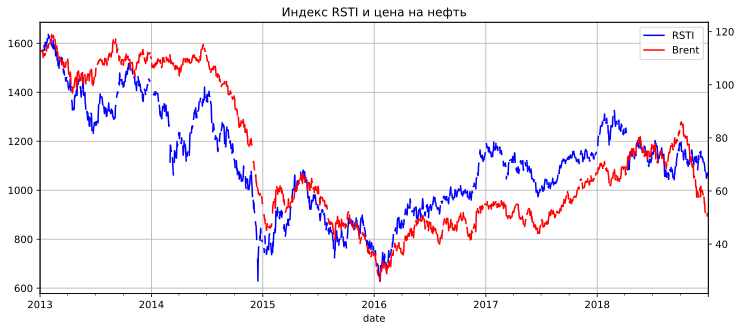

In [4]:
plt.figure(figsize=(12,5))
plt.title('Индекс RSTI и цена на нефть')

ax1 = df.rsti_price.plot(color='blue', grid=True, label='RSTI')
ax2 = df.brent_price.plot(color='red', grid=True, secondary_y=True, label='Brent')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=1)
plt.show()

In [5]:
# для расчёта корреляции необходимо удалить пропущенные значения
corr = df.dropna().rsti_price.corr(
    df.dropna().brent_price
)
"Correlation is {:.3}".format(corr)

'Correlation is 0.85'

In [6]:
pct_corr = df.dropna().rsti_price.pct_change().corr(
    df.dropna().brent_price.pct_change()
)

"Percent change correlation is {:.3}".format(pct_corr)

'Percent change correlation is 0.411'

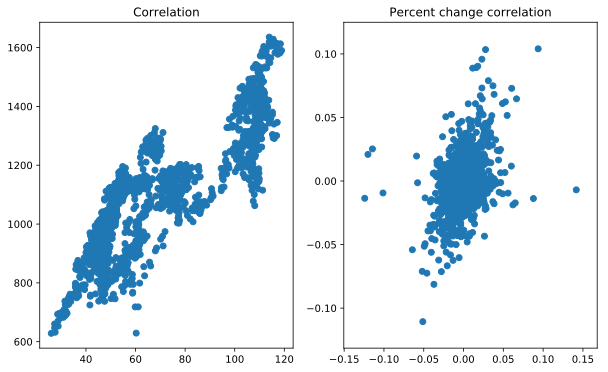

In [7]:
plt.subplot(1, 2, 1)
plt.scatter(
    df.dropna().brent_price,
    df.dropna().rsti_price);
plt.title('Correlation')

plt.subplot(1, 2, 2)
plt.scatter(
    df.dropna().rsti_price.pct_change(),
    df.dropna().brent_price.pct_change());
plt.title('Percent change correlation');

In [8]:
# Add a constant to the DataFrame x
reg_def = sm.add_constant(df.dropna())

# Fit the regression of y on x
result = sm.OLS(reg_def.rsti_price, reg_def[['const', 'brent_price']]).fit()

# Print out the results
result.summary()

C:\Users\parsh\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rsti_price   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     3807.
Date:                Fri, 12 Jul 2019   Prob (F-statistic):               0.00
Time:                        16:03:01   Log-Likelihood:                -8987.6
No. Observations:                1469   AIC:                         1.798e+04
Df Residuals:                    1467   BIC:                         1.799e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         620.3612      8.452     73.397      0.000     603.782     636.941
brent_price     6.8799      0.112     61.699      0.000       6.661       7.099
==============================================================================
Omnibus:                       67.592   Durbin-Watson:                   0.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.217
Skew:                          -0.132   Prob(JB):                     1.67e-07
Kurtosis:                       2.336   Cond. No.                         223.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
df_monthly = df.resample('M').last()
df_monthly.head()

,rsti_price,brent_price
date,,
2013-01-31,1622.13,115.55
2013-02-28,1534.41,112.20
2013-03-31,1460.04,108.46
2013-04-30,1407.21,101.53
2013-05-31,1331.43,100.43
